In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_json('../Dataset_Clean.json')

In [3]:
label_columns = [f'A_{i}' for i in range(1, 8)]
long_df = pd.melt(df, id_vars=['id', 'text'], value_vars=label_columns,
                  var_name='annotator', value_name='label_list')

In [4]:
# Function to safely extract labels
def extract_labels(label_list):
    if isinstance(label_list, list) and len(label_list) >= 2:
        l1 = label_list[0]
        l2 = label_list[1]
        # Combine them with an underscore for a single categorical label
        full = f"{l1}_{l2}"
        return full, l1, l2
    else:
        # Return None or a placeholder for invalid/missing labels
        return None, None, None

In [6]:
# Apply the function to the 'label_list' column
labels_df = long_df['label_list'].apply(lambda x: pd.Series(extract_labels(x)))
labels_df.columns = ['full_label', 'L1_label', 'L2_label']

In [7]:
# Join these new columns back to our long DataFrame
agreement_df = pd.concat([long_df, labels_df], axis=1)

# Clean up by removing rows where the label was invalid
agreement_df.dropna(subset=['full_label'], inplace=True)

## Pairwise Agreement with a Heatmap

A heatmap provides a "bird's-eye view" of your team's alignment. Before diving into complex statistics, this visual tells a powerful story. Dark squares mean high agreement and a healthy process. Light squares are a warning sign that specific pairs of annotators are not aligned.

In [8]:
# Create a pivot table to have annotators as columns and documents as rows
pivot_df = agreement_df.pivot(index='id', columns='annotator', values='full_label')


In [9]:
# Get the list of annotators from the columns
annotators = pivot_df.columns

# Initialize an empty DataFrame to store the agreement scores
agreement_matrix = pd.DataFrame(index=annotators, columns=annotators, dtype=float)

In [10]:
# --- 2. Calculate Pairwise Percentage Agreement ---
# We iterate through every possible pair of annotators
for i in range(len(annotators)):
    for j in range(len(annotators)):
        annotator1 = annotators[i]
        annotator2 = annotators[j]

        if i == j:
            # An annotator always agrees 100% with themselves
            agreement_matrix.loc[annotator1, annotator2] = 1.0
            continue

        # Compare the labels for the two annotators
        # The result is a boolean Series (True for agreement, False for disagreement)
        agreements = (pivot_df[annotator1] == pivot_df[annotator2])

        # The percentage agreement is the mean of this boolean series
        # (since True=1 and False=0)
        percentage = agreements.mean()
        agreement_matrix.loc[annotator1, annotator2] = percentage

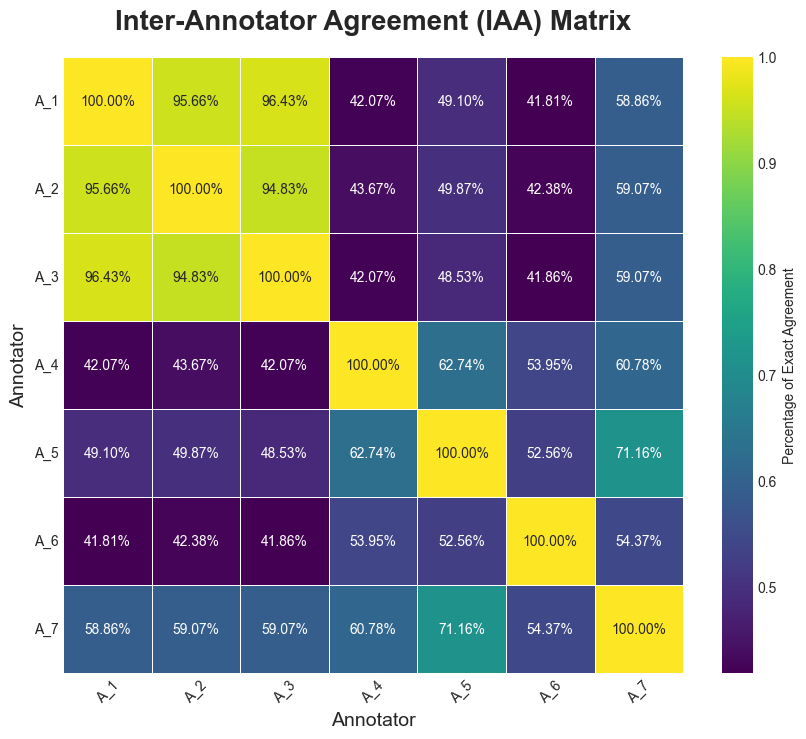

In [11]:
# --- 3. Create the Professional Heatmap Visualization ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 8))

# Use seaborn's heatmap function
sns.heatmap(agreement_matrix, annot=True, fmt=".2%", cmap='viridis',
            linewidths=.5, cbar_kws={'label': 'Percentage of Exact Agreement'})

# --- Title and Labels ---
ax.set_title('Inter-Annotator Agreement (IAA) Matrix', fontsize=20, weight='bold', pad=20)
ax.set_xlabel('Annotator', fontsize=14)
ax.set_ylabel('Annotator', fontsize=14)
ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=0)

plt.show()

**Interpreting This Plot**: This heatmap shows the percentage of times any two annotators assigned the exact same hierarchical label. A value of 85% between A_1 and A_2 means they agreed on the full L1 and L2 label for 85% of the items. Look for any rows or columns that are consistently lighter than others—this would indicate an annotator who needs more training or whose understanding of the guidelines differs from the group.